## LLM

In [8]:
import sys
sys.path.insert(0, '../src/')

import matplotlib.pyplot as plt
from tokenizer import TokenizerBPE
from data_handling import normalize_to_ascii
import numpy as np
import re

import os
import tensorflow as tf
import pickle as pkl
from tqdm.notebook import tqdm
import json

# disable gpu for testing purposes
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


## QuAC

In [11]:
with open('../corpus/QuAC_v0.2.json', 'r', encoding='utf-8') as f:
    quac = json.load(f)

data = quac["data"]
length = len(data)
print("QuAC length: ", length)

QuAC length:  11567


In [12]:
context_list = []

question_grouped = []
answer_grouped = []

for article in quac["data"]:
    for paragraph in article['paragraphs']:
        question_grouped.append([])
        answer_grouped.append([])
        context_list.append(paragraph['context'].replace(" CANNOTANSWER", ""))
        for qa in paragraph['qas']:
                question = qa['question']
                answer = qa['answers'][0]["text"]

                question_grouped[-1].append(question)
                answer_grouped[-1].append(answer)

In [13]:
len_list = [len(x) for x in context_list]

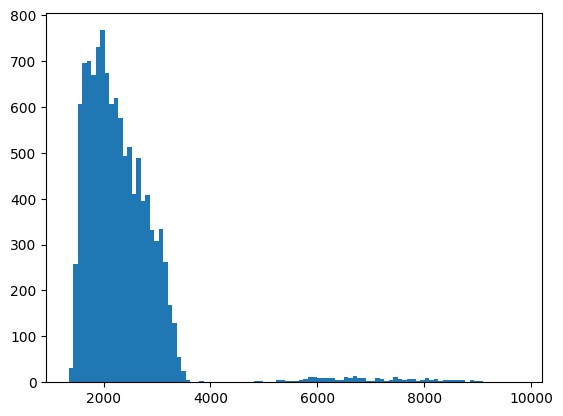

In [14]:
plt.hist(len_list, bins=100)
plt.show()

In [17]:
sys.path.insert(0, '../')
tokenizer = pkl.load(open("../tokenizers/tokenizer_superQA_24k.pkl", "rb"))
tokenizer.create_hash()
tokenizer.add_special_tokens(["<s>", "</s>", "<q>", "<a>", "<pad>"])

In [18]:
def fused_sqa(story_list, question_grouped_list, answer_grouped_list):
    q ="<q>"
    a = "<a>"
    sos = "<s>"
    eos = "</s>"

    rcw = re.compile(r"\s+")

    corpus_list = []
    for story, question_list, answer_list in tqdm(list(zip(story_list, question_grouped_list, answer_grouped_list))):
        story = story.replace("\n", " ").replace("\r", " ")
        story = rcw.sub(" ", story).strip()
        sqa = [sos, normalize_to_ascii(story).lower()]
        for question, answer in zip(question_list, answer_list):
            question = question.replace("\n", " ").replace("\r", " ")
            question = rcw.sub(" ", question).strip()
            answer = answer.replace("\n", " ").replace("\r", " ")
            answer = rcw.sub(" ", answer).strip()
            sqa.append(q)
            sqa.append(normalize_to_ascii(question).lower())
            sqa.append(a)
            sqa.append(normalize_to_ascii(answer).lower())
        sqa.append(eos)
        corpus_list.append("".join(sqa))
        
    return corpus_list

In [ ]:
fused = fused_sqa(context_list, question_grouped, answer_grouped)
corpus_encoded = [tokenizer.encode(line.lower()) for line in tqdm(fused)]

pkl.dump(corpus_encoded, open('../corpus/corpus_clean/corpus_quac_sqa_24k', 'wb'))

  0%|          | 0/11567 [00:00<?, ?it/s]

  0%|          | 0/11567 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'corpus/corpus_clean/corpus_quac_sqa_24k'

In [23]:
def pad_corpus(corpus, max_length, tokenizer):
    pad_token = tokenizer.token_to_idx["<pad>"]
    padded_corpus = []
    for line in tqdm(corpus):
        if line.shape[1] < max_length:
            padding = tf.repeat(tf.constant([[pad_token]]), max_length - line.shape[1], axis=1)
            padded_line = tf.concat([line, padding], axis=1)
        else:
            padded_line = line[:, :max_length]
        padded_corpus.append(padded_line)
    return tf.concat(padded_corpus, axis=0)

In [24]:
corpus_encoded = pkl.load(open('../corpus/corpus_clean/corpus_quac_sqa_24k', 'rb'))
corpus_padded = pad_corpus(corpus_encoded, 768, tokenizer)
pkl.dump(corpus_padded, open('../corpus/corpus_clean/corpus_quac_sqa_24k_padded', 'wb'))

  0%|          | 0/11567 [00:00<?, ?it/s]

## 